Spiking Neural Belief Propagation Decoding for Short Block Length LDPC Codes
---
Alexander von Bank, Eike-Manuel Edelmann, Sisi Miao, Jonathan Mandelbaum and Laurent Schmalen

We approximate the sum-product decoder's update equations using Spiking Neural Networks (SNNs).
The SNN fires if the lowest incoming likelihood value at a parity check node is below a adjustable threshold.

The full paper [1] is available on arXiv and IEEE Xplore.

This jupyter notebook shows an exemplary implementation and usage of the Elena-SNN algorithm. The code is implemented close to the description in [1]. The comments within the source code assume prior knowledge in the field of message passing on factor graphs and assume that you have completely studied the ideas and notations in [1]. In specific, this notebook contains:
* Generic implementation of the Elena-SNN algorithm, parallelized to handle multiple batches of data blocks in parallel. The class is implemented with pyTorch according to Norse [2] and can run on CPUs or GPUs.
* Effects of the parameters on the BER.
* Some helper classes.

[1] A. von Bank, E.-M. Edelmann, S. Miao, J. Mandelbaum, L. Schmalen, "Spiking Neural Belief Propagation Decoding for Short Block Length LDPC Codes" in IEEE Trans. Commun., vol. ??, no. ??, pp. ???-???, ???. ????.

[2] C. Pehle and J. E. Pedersen, "Norse - A deep learning library for spiking
neural networks," Jan. 2021, documentation: https://norse.ai/docs/.


---

This work has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation program (grant agreement No. 101001899). Parts of this work were carried out in the framework of the CELTIC-NEXT project AI-NET-ANTILLAS (C2019/3-3) (grant agreement 16KIS1316) and within the project Open6GHub (grant agreement 16KISK010) funded by the German Federal Ministry of Education and Research (BMBF).

---

Copyright (c) 2023-2024 Alexander von Bank - Communications Engineering Lab (CEL), Karlsruhe Institute of Technology (KIT)

<sup> Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

<sup> The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

<sup> THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
# Import external libraries
import numpy as np
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torch.nn as nn
import torch.nn.functional as func

from scipy.sparse import csc_matrix as sp_mat

import os

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

In [3]:
def read_alist_file(filename):
    # H = read_alist_file("<path/filename>") <== Usage
    try:
        fileobject = open(filename, 'r');
    except:
        print("Error 404 File not found");

    text = fileobject.readline();
    int_list = text.split();
    N = int(int_list[0]); 
    M = int(int_list[1]);

    text = fileobject.readline();
    int_list = text.split();
    max_sum_dv = int(int_list[0]);
    max_sum_dc = int(int_list[1]);

    text = fileobject.readline();
    int_list = text.split();
    sum_dv = np.zeros(N);
    sum_dv = np.array(int_list,dtype='int');

    text = fileobject.readline();
    int_list = text.split();
    sum_dc = np.zeros(M);
    sum_dc = np.array(int_list,dtype='int');

    one_pos_row_wise = np.zeros((N,max_sum_dv));
    for n in range(N):
        text = fileobject.readline();
        int_list = text.split();
        #print("Dim of input: "+str(len(int_list)))
        one_pos_row_wise[n][:] = np.array(int_list,dtype='int');

    one_pos_col_wise = np.zeros((M,max_sum_dc));
    for m in range(M):
        text = fileobject.readline();
        int_list = text.split();
        one_pos_col_wise[m][:] = np.array(int_list,dtype='int');

    fileobject.close();

    idx_row = np.nonzero(one_pos_row_wise > 0);
    one_cnt = np.size(idx_row[0]);

    row_i = np.zeros(one_cnt);
    col_i = np.zeros(one_cnt);
    for n in range(one_cnt):
        row_i[n] = one_pos_row_wise[int(idx_row[0][n])][int(idx_row[1][n])];
        col_i[n] = idx_row[0][n];

    H = sp_mat( (np.ones(one_cnt), (row_i-1,col_i)) , shape=(M,N));

    return H;

########################

sigmoid = nn.Sigmoid()

Spiking Neural Networks
---
Below we define the dynamics of a spiking neurons, a simple leaky integrate neuron (LI) and a leaky integrate-and-fire neuron (LIF)

In [4]:
def LI(x,v,i,tau_mem_inv, tau_syn_inv,dt=1e-3):
    i_jump = i + x
    # compute voltage updates
    dv = dt * tau_mem_inv * ((0 - v) + i_jump)
    v = v + dv

    # compute current updates
    di = -dt * tau_syn_inv * i_jump
    i = i_jump + di

    return v,i

def heaviside(data):
    r"""
    From Norse
    """
    return torch.gt(data, torch.as_tensor(0.0).to(data.device)).to(data.device).to(data.dtype)  # pragma: no cover

def LIF(input_spikes,v,i,tau_mem_inv,tau_syn_inv,dt=1e-3):
    # compute current jumps
    i_jump = i + input_spikes
    # compute voltage updates
    dv = dt * tau_mem_inv * ((0 - v) + i_jump)
    v_decayed = v + dv

    # compute current updates
    di = -dt * tau_syn_inv * i_jump
    i_decayed = i_jump + di

    # compute new spikes
    z_new = heaviside(v_decayed - 1.0)
    # compute reset
    v_new = (1 - z_new.detach()) * v_decayed

    return z_new, v_new, i_decayed

In the following, incoming spikes of different amplitudes are applied to the LIF neuron.

Test different values for tau_mem and tau_syn to get a feeling how spiking neurons behave.

Text(0.5, 1.0, 'Synaptic current')

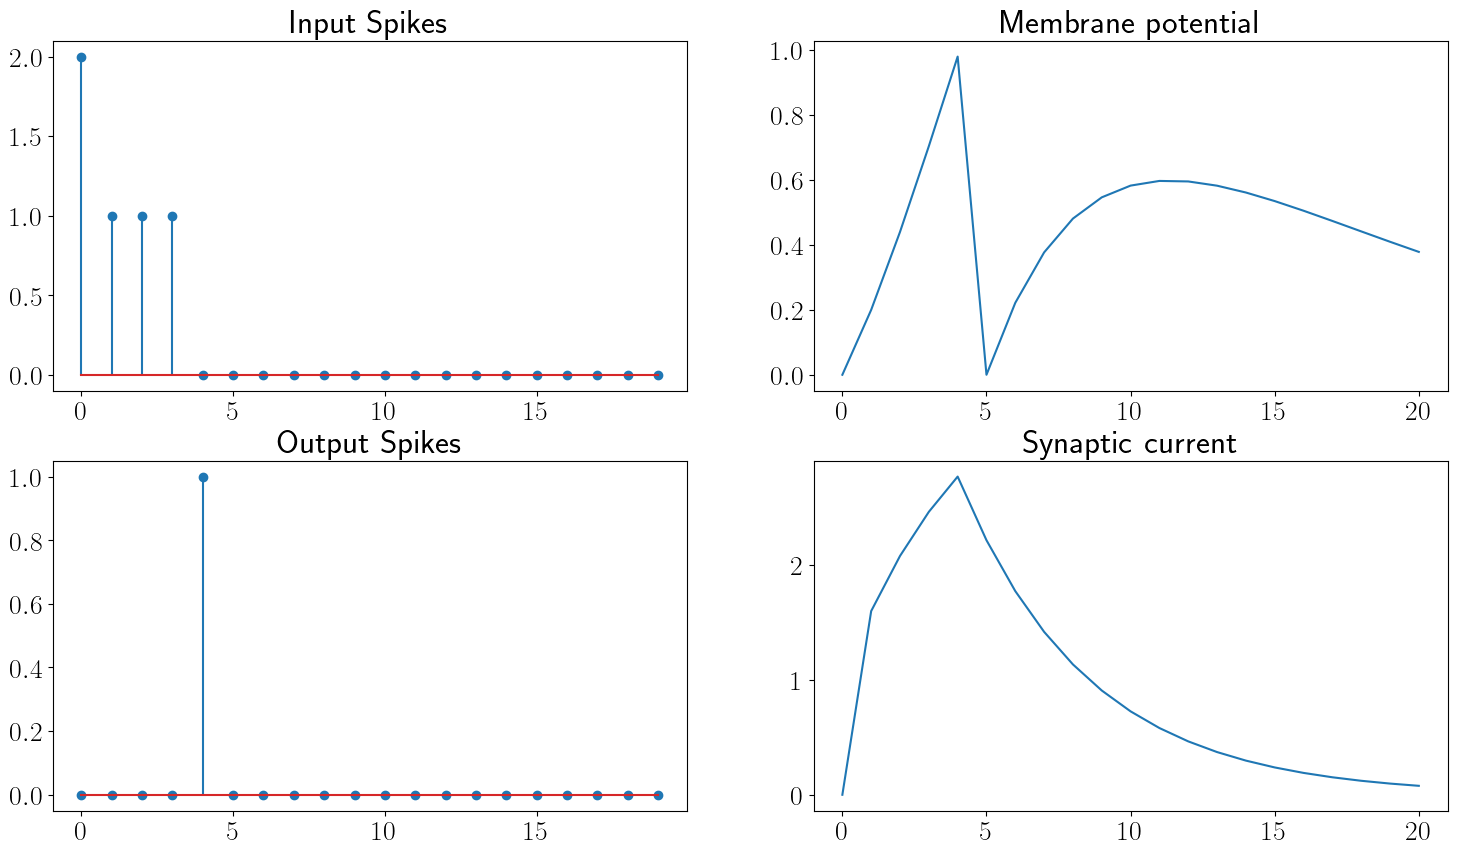

In [5]:
input_spikes    = torch.zeros((20,1),device=device)

#Define input spikes and their amplitude here
input_spikes[0] = 2
input_spikes[1] = 1
input_spikes[2] = 1
input_spikes[3] = 1

output_spikes    = torch.zeros((20,1),device=device)
v               = torch.zeros((21,1),device=device)
i               = torch.zeros((21,1),device=device)

#Adjust the membrane and synaptic time constant here
tau_mem = 10e-3
tau_syn = 5e-3
#tau_mem = 1e-3
#tau_syn = 1e-3

for ts in range(output_spikes.shape[0]):
    output_spikes[ts], v[ts+1], i[ts+1] = LIF(input_spikes[ts],v[ts],i[ts],1/tau_mem,1/tau_syn,dt=1e-3)


plt.figure()

plt.subplot(221)
plt.stem(input_spikes.detach().cpu().numpy())
plt.title("Input Spikes")

plt.subplot(223)
plt.stem(output_spikes.detach().cpu().numpy())
plt.title("Output Spikes")

plt.subplot(222)
plt.plot(v.detach().cpu().numpy())
plt.title("Membrane potential")

plt.subplot(224)
plt.plot(i.detach().cpu().numpy())
plt.title("Synaptic current")


In [6]:
##############################################################
# This function creates the indices corresponding to the
# variable and check nodes, with the indices a sparse matrix
# multiplication of binary matrices is implemented by slicing 
def make_SNN(H):
    #Transform Parity Check Matrix to integer
    H = H.astype(int)
    #Calculate maximum check node degree
    d_c_max = np.max(np.sum(H,axis=1))

    #Create index matrix, each nonzero element in H gets ascending number
    idx = np.zeros_like(H)
    idx[np.nonzero(H)] = np.cumsum(H[np.nonzero(H)])
    #For regular LDPC codes d_c_max is constant, thus create matrix for checknode input indices
    cn_idx = np.zeros((np.sum(H),d_c_max-1))
    #Loop over SPC
    for n in range(H.shape[0]):
        #Each row of H creates d_c_max-1 checks
        for k in range(d_c_max):
            #Input all indices except the k-th one (extrinsic message)
            cn_idx[n*d_c_max+k] = idx[n][np.delete(np.nonzero(H[n])[0],k)]
    #Convert counting from 1,...,N to 0,...,N-1 for indexing
    cn_idx -= 1

    #Create 2D lists, inputs to variable nodes from check nodes and input to variable nodes from channel input values
    vn_idx = [[]]
    llr_idx = [[]]
    for n in range(np.sum(H)-1):
        vn_idx.append([])
        llr_idx.append([])

    #Create 1D list for variable node messages to output
    out_idx = []

    #Transpose indices
    idx = idx.T
    #Loop over colums
    for n in range(H.shape[1]):
        nz = np.nonzero(idx[n])[0]
        #All nonzero elements in column define "n-th" output bit
        out_idx.append((idx[n][nz]-1).tolist())
        for k in range(len(nz)):
            #Exclude "k-th" message (extrinsic message)
            vn_idx[(idx[n][nz[k]]-1)] = (idx[n][np.delete(nz,k)]-1).tolist()
            #All nonzero elements in column need "n-th" channel input value
            llr_idx[(idx[n][nz[k]]-1)].append(n)

    return cn_idx, vn_idx, llr_idx, out_idx

class SNN_Decoder(nn.Module):
    def __init__(self, N, H, device, dt=0.001):
        super(SNN_Decoder, self).__init__()
        self.device = device;

        self.N               =  N

        self.H               = H

        self.dt              = dt

        self.d_c_max     = np.max(np.sum(self.H,axis=1)).astype(int)
        self.No_messages = np.sum(self.H).astype(int) 
        
        #############################################################################################################################################
        # SNN Weights and Biases                                                                                                                    #
        #############################################################################################################################################

        #Indices of the messages beloning to the corresponding SPC unit
        cn_idx, vn_idx, llr_idx, out_idx = make_SNN(H)

        self.checknode_indices      = cn_idx
        self.varnode_input_messages = vn_idx
        self.varnode_input_LLR      = llr_idx
        self.varnode_to_LLR         = out_idx

        ####################################################################################################################
        # Weights dimensions:                                                                                              #
        # (Number of '1' in the Parity Check Matrix, Batch Size, Output Size of Linear Layer, Input Size of Linear Layer)  #
        # Matmul casts the Linear Layers to the Inputs dimensions                                                          #
        ####################################################################################################################
        
        #Hidden layer to combine the LIF neuron outputs
        self.fc_0   = nn.Parameter(torch.zeros((1,1,1,(self.d_c_max-1)),device=device).float(),
                                   requires_grad=False)
        self.fc_0[0,0,0,::] =  1


        #Input layer of the SNN multiplier of ternary values (-1,0,1)
        self.fcmul0   = nn.Parameter(torch.zeros((1,1,2,2),device=device).float(),
                                   requires_grad=False)
        self.fcmul0.data[0,0,0,0] =  1
        self.fcmul0.data[0,0,0,1] =  1
        self.fcmul0.data[0,0,1,0] =  1
        self.fcmul0.data[0,0,1,1] = -1

        #Output layer of the SNN multiplier of ternary values (-1,0,1)
        self.fcmul1   = nn.Parameter(torch.zeros((1,1,1,2),device=device).float(),
                                   requires_grad=False)
        self.fcmul1.data[0,0,0,0] =  1
        self.fcmul1.data[0,0,0,1] = -1

        #LI Neuron time constants
        self.tau_mem = 0.001
        self.tau_syn = 0.001

        #Bias (Theta 1)
        self.th_bias = 2

        #Amplitude of the incrementation (Theta 2)
        self.amp = 1

    def forward(self, x):
        #Define how may iterations the BP will run
        seq_length=20

        #Get the batch size
        batch_size,_ = x.shape

        #Output value buffer
        out           = torch.zeros(x.shape[0], self.N, device=self.device)
        #Number of hidden spikes get accumulated here
        hidden_spikes = 0

        #Buffer for feed back of the Checknode Messages to the Variable Nodes
        z_rec = torch.zeros( (x.shape[0],self.No_messages), device=self.device)    

        #States of the neurons
        v0 = 0
        i0 = 0
        v1 = 0
        i1 = 0
        v2 = 0
        i2 = 0
        v3 = 0
        i3 = 0

        #Iterate BP
        for ts in range(seq_length):
            # Output: (Batchsize , No. Messages)
            # Input LLR to corresponding "1" entries in parity check matrix
            z = x[::,self.varnode_input_LLR].flatten(-2)
            
            # Checknode messages to corresponding varnodes (Iteration over No_Messages if VN degree not even)
            z += torch.sum(z_rec[::,self.varnode_input_messages],axis=2)

            # Varnode messages to corresponding varnodes (output) (Iteration over No_Messages if VN degree not even)
            out = torch.sum(z[::,self.varnode_to_LLR],axis=2)

            # Select corresponding VN messages for CN update Output: (Batchsize, No. Messages, dv - 1)
            z = z[::,self.checknode_indices]

            ############################################################################
            #                            Elena-SNN* part                               #
            ############################################################################
            signs = torch.prod(torch.sign(z),axis=2,keepdim=True)            

            ############################################################################
            # Extended part which deactivates the incrementation of the likelihoods    #
            ############################################################################

            ############################################################################
            # Approximation of the Comparator with LIF neurons

            #If a value is below bias (Theta_1), a positive value occurs at neuron input and charges Neuron
            #High weight and low time constants ensure the neuron directly fires a pulse
            z    = -10*(torch.abs(z)-self.th_bias)

            #LIF neuron with low time constants, input is inverted tau mem, so time constants are 1ms
            z,v0,i0 = LIF(z,v0,i0,1000,1000,dt=self.dt);
            #Keep count of emitted spikes to calculate efficiency later on
            hidden_spikes += torch.sum(z)
            #
            #############################################################################

            ############################################################################
            # Approximation of the AND with LIF neurons
            #
            #Combine spikes of all dc - 1 LIF neurons, amplify the result and send them to neurons with
            #small time constants to approximate an OR element
            #The combination of Inverted Threshold and OR acts as Threshold with AND but with fewer spikes
            z    = 10*torch.matmul(self.fc_0,z.reshape((z.shape[0],z.shape[1],z.shape[2],1))).flatten(-2)
            z,v1,i1 = LIF(z,v1,i1,1000,1000,dt=self.dt);
            #Keep count of emitted spikes to calculate efficiency later on
            hidden_spikes += torch.sum(z)

            # Invert message, if one LIF neuron spikes, the output is 0
            # Otherwise it's 1
            z = 1-z
            #
            #############################################################################

            ############################################################################
            # Approximation of the multiplication in front of the LI neuron with LIF neurons
            z       = torch.cat((z,signs),axis=2)
            z       = torch.matmul(self.fcmul0,z.reshape((z.shape[0],z.shape[1],z.shape[2],1))).flatten(-2)
            z       = 0.501/1*z
            z,v2,i2 = LIF(z,v2,i2,1000,1000,dt=self.dt);
            z       = torch.matmul(self.fcmul1,z.reshape((z.shape[0],z.shape[1],z.shape[2],1))).flatten(-2)
            z    = z.flatten(-2)

            #Scale with amplitude (Theta_2) at this point, since this LIF approximation of mult. can only handle ternary values
            z = self.amp * z
            #
            #############################################################################
            
            #LI after multiplication (Relevant for Elena-SNN*, minor relevance for Elena-SNN)
            v3,i3 = LI(z,v3,i3,1/self.tau_mem, 1/self.tau_syn,dt=self.dt);
            z_rec = v3.clone()

        del z

        #Spikerate = Number of Spikes emitted / (Number of parallel computed Codewords * No of Ones in H * Timesteps * No of LIF Neurons)
        spikerate = hidden_spikes/(x.shape[0]*self.No_messages*seq_length*(self.d_c_max))

        return out, spikerate
        

In [7]:
#Get current path
notebook_path = os.path.abspath("Notebook.ipynb")
Decode_alist = os.path.join(os.path.dirname(notebook_path), "FG_273-191.alist")

#Read .alist file to get Parity Check matrix
H = read_alist_file(Decode_alist).toarray();

N = H.shape[1]

#Create Elena-SNN
decoder = SNN_Decoder(N, H, device, dt=0.001)
decoder.to(device)


SNN_Decoder()

In [8]:
#Define Eb/N0 values to simulate 
EBN0_dB = np.arange(0,4.0,0.5)

#Channel reliability Es/N0 that is used throughout the simulation
op_point = 3.5

#Epochs
EPOCHS = 5

#Number of codewords
CW = 200

#Keep this fixed since we use a (273,191) FG LDPC code
N = 273
K = 191
rate = K/N

ERRORS   = np.zeros(EBN0_dB.shape)
F_ERRORS = np.zeros(EBN0_dB.shape)
BER      = np.zeros(EBN0_dB.shape)
FER      = np.zeros(EBN0_dB.shape)

for idx_P, snr_i in enumerate(EBN0_dB):
    print("EBN0: "+str(snr_i))
    for epoch_cnt in range(EPOCHS):
        bits = torch.zeros((CW,N),device=device);                                    #Zero codeword
        x      = -2*(bits-0.5)          # Cast 1 to -1 and 0 to 1                    #BPSK

        esn0_dB = snr_i + 10 * np.log10( rate )                                      #Convert Eb/N0 to Es/N0
        sigma = np.sqrt( 0.5*(10**(-esn0_dB / 10)) );                                #Calculate sigma
        noise = torch.randn(x.shape,device=device);                                  #Create noise
        noise = sigma * noise;                                                       #Scale noise to correct SNR
        y = x + noise                                                                #Apply noise
        
        y = 4*10**(op_point/10) * y                                                  # Channel output to LLR

        outputs, reg_2 = decoder(y)                                                  #Apply Elena-SNN

        recv_bits = torch.where(sigmoid(-1*outputs)>=0.5,1,0)                        #Hard decision
        ERRORS[idx_P] += torch.sum(torch.abs(recv_bits-bits)).detach().cpu().numpy() #Calculate bit errors
        F_ERRORS[idx_P] += torch.sum(torch.where(torch.sum(torch.abs(recv_bits-bits),axis=1)>0,1,0)).detach().cpu().numpy() #Calculate frame errors
        
BER = ERRORS / (N*CW*EPOCHS)                                                         #Calculate BER
FER = F_ERRORS / (CW*EPOCHS)                                                         #Calculate FER

EBN0: 0.0
EBN0: 0.5
EBN0: 1.0
EBN0: 1.5
EBN0: 2.0
EBN0: 2.5
EBN0: 3.0
EBN0: 3.5


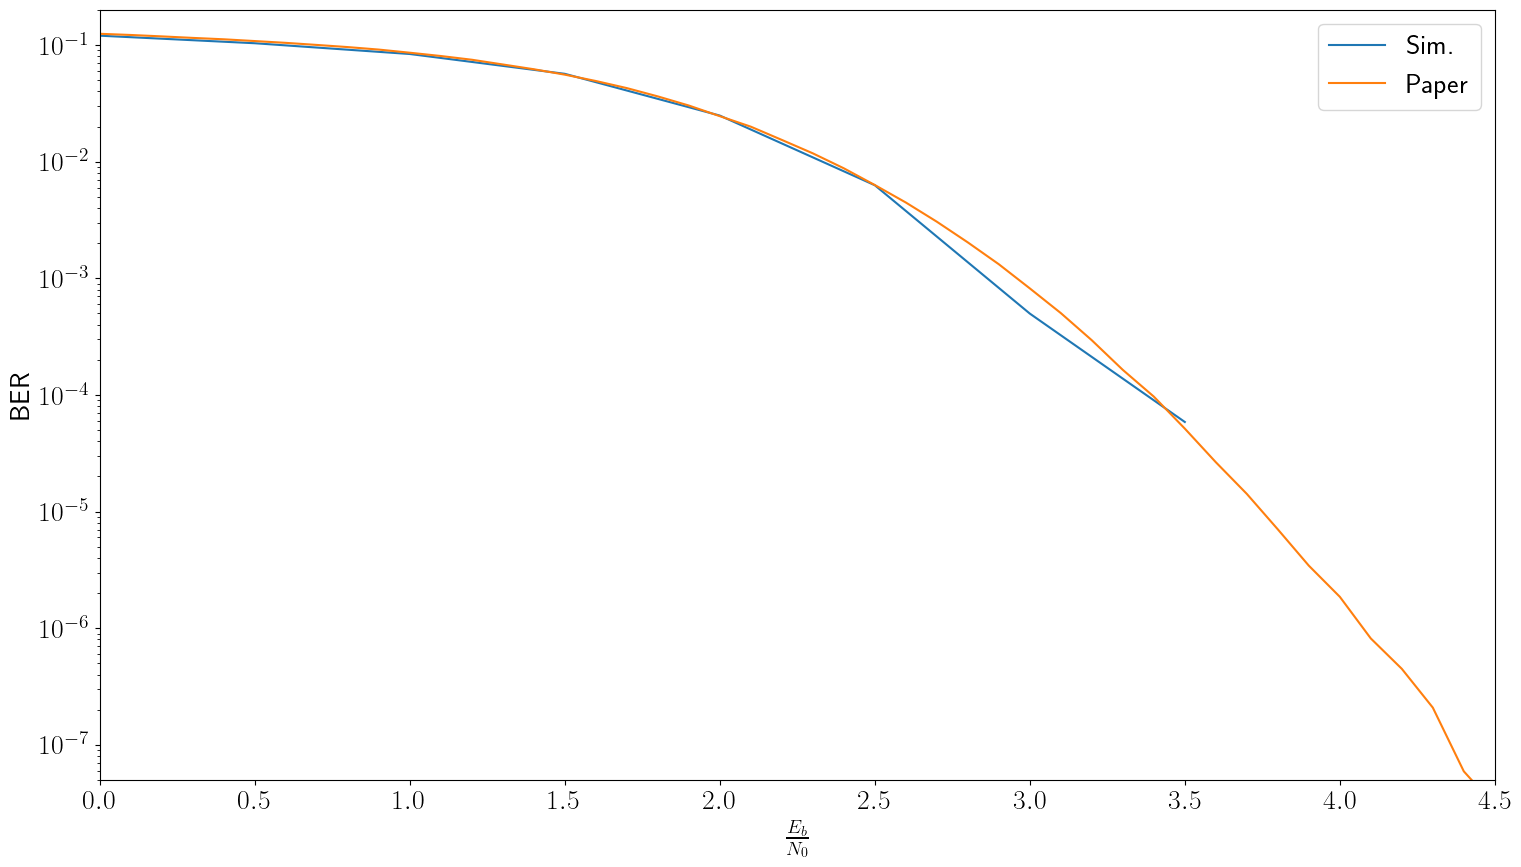

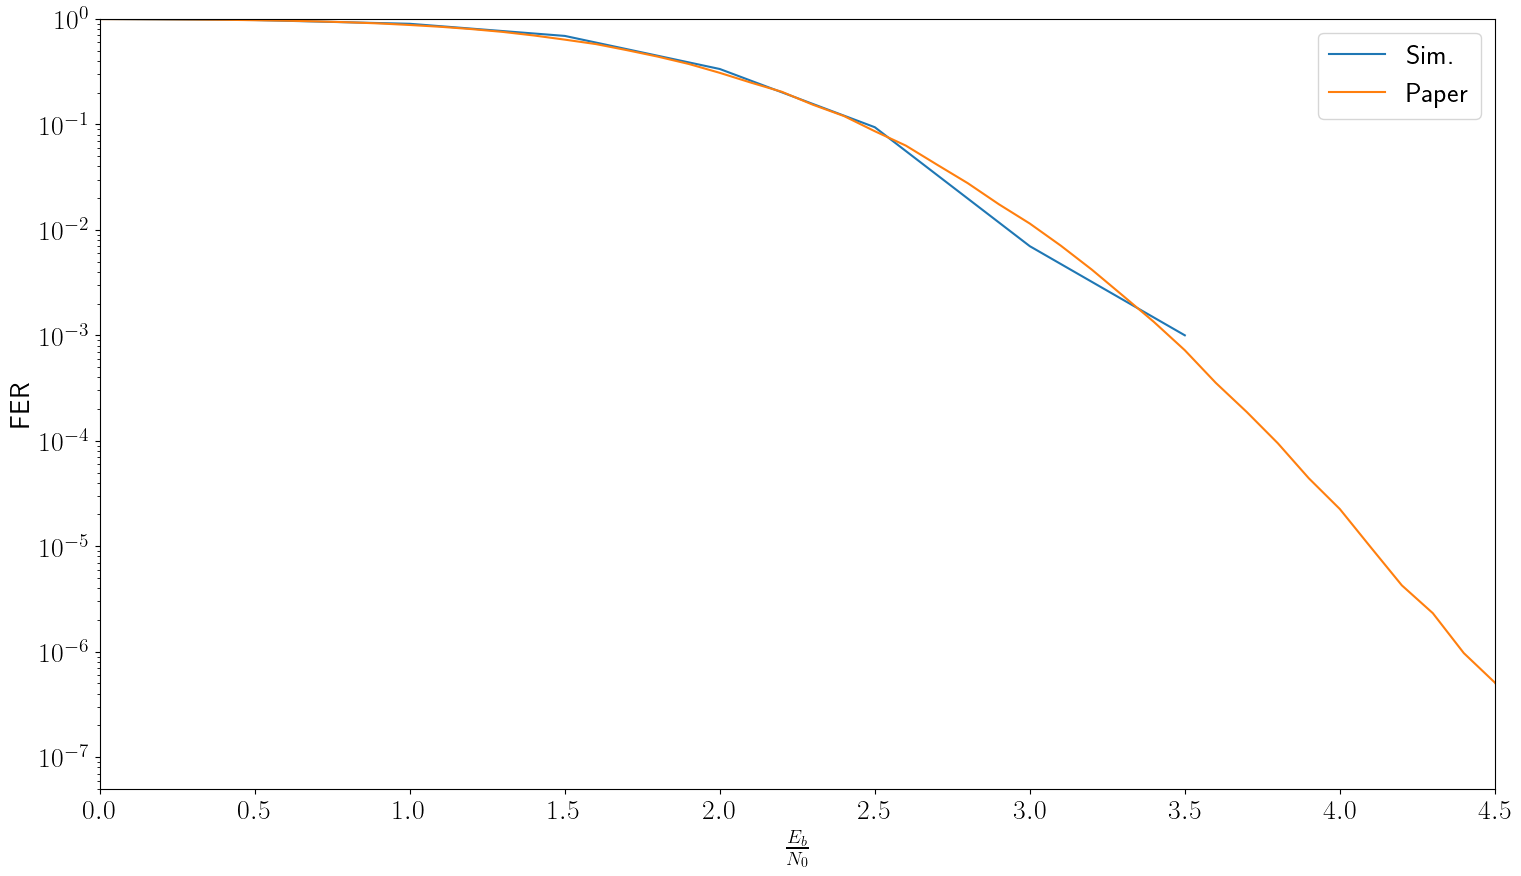

In [9]:
Paper_EBN0_dB = np.arange(0,5.1,0.1)
Paper_BER = np.array( [ 1.24844293e-01,1.21950681e-01,1.18588063e-01,1.15107749e-01,
                    1.11980314e-01,1.08146283e-01,1.04380209e-01,1.00177696e-01,
                    9.60078534e-02,9.14014660e-02,8.59165445e-02,8.05009424e-02,
                    7.48015707e-02,6.81202094e-02,6.20061780e-02,5.57209424e-02,
                    4.91596859e-02,4.27315183e-02,3.62655497e-02,3.02879581e-02,
                    2.45518325e-02,1.99482723e-02,1.53648168e-02,
                    1.17875445e-02, 
                    8.77079058e-03, 6.30443979e-03, 4.46521990e-03, 3.05641361e-03, 
                    2.03126702e-03, 1.31959686e-03, 8.19230366e-04, 5.03057592e-04,
                    2.94204188e-04, 1.63937173e-04, 9.67382199e-05, 5.14240838e-05, 
                    2.64921466e-05, 1.41722513e-05, 7.03560209e-06, 3.43664921e-06,
                    1.85863874e-06, 8.16230366e-07, 4.48167539e-07, 2.08376963e-07,
                    5.92161172e-08, 3.01318681e-08, 1.18095238e-08, 7.17948718e-09,
                    2.47619048e-09, 4.10256410e-10, 5.86080586e-10] )

Paper_FER = np.array(   [9.9620e-01, 9.9470e-01, 9.9198e-01, 9.8784e-01, 9.8160e-01, 9.7230e-01,
                         9.6290e-01, 9.4808e-01, 9.2950e-01, 9.0666e-01, 8.7592e-01, 8.4180e-01,
                         8.0030e-01, 7.5306e-01, 6.9682e-01, 6.3614e-01, 5.7750e-01, 5.0576e-01,
                         4.3890e-01, 3.7396e-01, 3.0800e-01, 2.4910e-01, 2.0380e-01, 1.5370e-01,
                         1.2014e-01, 8.6120e-02, 6.2940e-02, 4.1620e-02, 2.7680e-02, 1.7500e-02,
                         1.1472e-02, 7.0800e-03, 4.1960e-03, 2.3800e-03, 1.3420e-03, 7.2200e-04,
                         3.5400e-04, 1.8726e-04, 9.4780e-05, 4.4100e-05, 2.2540e-05, 9.7600e-06, 
                         4.2600e-06, 2.3200e-06, 
                         9.70e-07, 5.10e-07, 2.06e-07, 1.32e-07, 
                         5.40e-08, 1.00e-08, 1.20e-08] )

plt.figure()
plt.semilogy(EBN0_dB,BER,label='Sim.')
plt.semilogy(Paper_EBN0_dB,Paper_BER,label='Paper')
plt.xlim(0,4.5)
plt.ylim(5e-8,0.2)
plt.xlabel("$\\frac{E_b}{N_0}$")
plt.ylabel("BER")
plt.legend()

plt.figure()
plt.semilogy(EBN0_dB,FER,label='Sim.')
plt.semilogy(Paper_EBN0_dB,Paper_FER,label='Paper')
plt.xlim(0,4.5)
plt.ylim(5e-8,1.0)
plt.xlabel("$\\frac{E_b}{N_0}$")
plt.ylabel("FER")
plt.legend()